In [2]:
# Connect to Github Data Repo
!git clone https://github.com/verma-aniket/CEE_266G_Data_Repo GitRepo

# Set up working directory
import os
wdir = 'GitRepo/Data'
os.chdir(wdir)

Cloning into 'GitRepo'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 36 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (36/36), 732.65 KiB | 4.82 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [3]:
# Import Libraries for Problem 1 and 2: Numpy, Matplotlib, and Pandas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Reservoir simulation

In [4]:
# Load data
data = pd.read_csv('FOL-daily.csv', delimiter=',', usecols=[4])
data = data.fillna(method='ffill') # fill in missing values using previous value
print(data)

# Reservoir/demand parameters and assumptions
K = 975 # Folsom Reservoir Capacity (TAF)
D = 3.5 # Daily demand (TAF/d)


        inflow
0     2.195702
1     2.840331
2     2.691570
3     1.251570
4     1.800992
...        ...
6316  5.520000
6317  6.648595
6318  5.478347
6319  7.412231
6320  5.785785

[6321 rows x 1 columns]


<ipython-input-4-ca10d121b92d>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill') # fill in missing values using previous value


In [5]:
# cubic feet per second to thousand acre-foot perday conversion
cfs_to_taf = 2.29568411*10**-5 * 86400 / 1000

# define stage-storage function
def storage_to_elevation(S): # from regression
  # Takes stoarge in TAF and returns elevation in feet
  return -0.000078*S**2 + 0.213526*S + 328.922121

# define hydropower parameters
downstream_wse = 134 # feet
turbine_max_outflow = 8600 # cubic feet per second
efficiency = 0.82

The capacity of the reservoir is 975 TAF. Assume the daily demand is 3.5 TAF. A function called "simulate_folsom" is written and reports the reliability, defined as the percentage of days in which demand was fully met.

In [6]:
# define simulate_folsom_A function
def simulate_folsom_A(Q, K, D):

  T = len(Q)
  S = np.zeros(T) # storage, TAF
  R = np.zeros(T) # release (for demand), TAF/d

  S[0] = K # start simulation full
  R[0] = D

  for t in range(1,T):
    S[t] = min(S[t-1] + Q[t-1] - R[t-1], K)

    # release is based on demand
    if S[t] + Q[t] > D:
      R[t] = D
    else:
      R[t] = S[t] + Q[t]

  # reliability metric
  reliability = R[R==D].size / float(T)

  return reliability, R, S, T


In [7]:
# Report Reliability
[rel_fol, R_fol, S_fol, T_fol] = simulate_folsom_A(data.inflow, K, D)
print("Folsom Lake reliability: {:.2f}% when K = {} TAF and D = {} TAF/day given Q from FOL-daily.csv".format(rel_fol*100, K, D))

Folsom Lake reliability: 99.56% when K = 975 TAF and D = 3.5 TAF/day given Q from FOL-daily.csv


 Add a new performance objective called "alteration" that quantifies the difference between the altered flow downstream of the reservoir and the unimpaired flow. Quantify this as: the sum over the full time period of the absolute value of the difference between the altered and unimpaired daily flow values, expressed as a percentage of the sum of the total unimpaired flow values.

In [8]:
# define simulate_folsom_B function
#    - update simulate_folsom_B function by adding alteration calculation
def simulate_folsom_B(Q, K, D):

  T = len(Q)
  S = np.zeros(T) # storage, TAF
  R = np.zeros(T) # release (for demand), TAF/d
  spill = np.zeros(T) # additional release for spill, TAF/d

  S[0] = K # start simulation full
  R[0] = D
  spill[0] = max(S[0] + Q[0] - R[0] - K, 0)  # calculate initial spill

  for t in range(1,T):

    # update storage
    S[t] = S[t-1] + Q[t-1] - R[t-1] - spill[t-1]

    # determine release
    if S[t] + Q[t] > D:
      R[t] = D
    else:
      R[t] = S[t] + Q[t]

    # calculate spill
    spill[t] = max(S[t] + Q[t] - R[t] - K, 0)

  # metrics- now looking at alteration and reliability
  alteration = np.abs(Q - spill).sum() / Q.sum()
  reliability = R[R==D].size / float(T)

  return reliability, alteration


In [9]:
# Report Alteration
[rel_fol, alt_fol] = simulate_folsom_B(data.inflow, K, D)
print("Folsom Lake alteration: {:.2f}% when K = {} TAF and D = {} TAF/day given Q from FOL-daily.csv".format(alt_fol*100, K, D))

Folsom Lake alteration: 50.61% when K = 975 TAF and D = 3.5 TAF/day given Q from FOL-daily.csv


Add a performance metric quantifying the daily hydropower generated.

In [10]:
# define simulate_folsom_C function
#    - update simulate_folsom_C function by adding hydropower calculation
def simulate_folsom_C(Q, K, D, downstream_wse, turbine_max_outflow, efficiency):
  # assume a constant downstream water elevation
  # (neglects the hydraulic effects of changing flowrate)

  T = len(Q)
  S = np.zeros(T) # storage, TAF
  WSE = np.zeros(T) # water surface elevation, ft
  R = np.zeros(T) # release (for demand), TAF/d
  spill = np.zeros(T) # additional release for spill, TAF/d

  S[0] = K # start simulation full
  WSE[0] = storage_to_elevation(S[0])
  R[0] = D
  spill[0] = max(S[0] + Q[0] - R[0] - K, 0)  # calculate initial spill

  for t in range(1,T):
    # update storage
    S[t] = S[t-1] + Q[t-1] - R[t-1] - spill[t-1]
    WSE[t] = storage_to_elevation(S[t])

    # determine release
    if S[t] + Q[t] > D:
      R[t] = D
    else:
      R[t] = S[t] + Q[t]

    # calculate spill
    spill[t] = max(S[t] + Q[t] - R[t] - K, 0)

  # metrics from before
  alteration = np.abs(Q - spill).sum() / Q.sum()
  reliability = R[R==D].size / float(T)

  # hydropower calculations
  h = WSE - downstream_wse # hydraulic head, feet
  turbine_outflow = np.clip((R+spill)/cfs_to_taf, 0, turbine_max_outflow) # this is a useful function
  power = efficiency * h * turbine_outflow / (1.181*10**4) # MW

  return S, R+spill, power, alteration, reliability

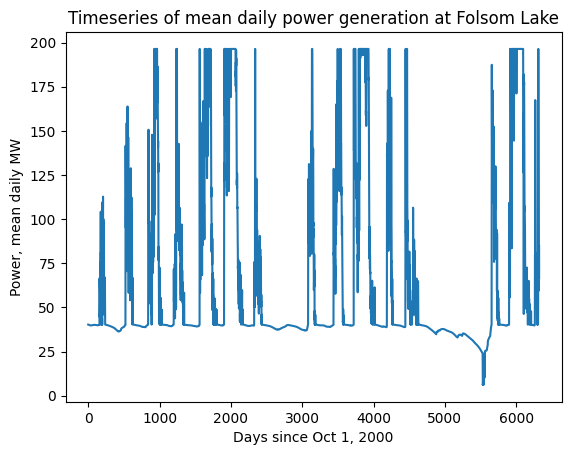

In [11]:
# Hydropower Generation Timeseries
S, R, power, altH, relH = simulate_folsom_C(data.inflow, K, D, downstream_wse, turbine_max_outflow, efficiency)

# add these results into the original dataframe
data['S_sim'] = pd.Series(S, index=data.index)
data['R_sim'] = pd.Series(R, index=data.index)
data['power_sim'] = pd.Series(power, index=data.index)

data.power_sim.plot()
plt.xlabel('Days since Oct 1, 2000')
plt.ylabel('Power, mean daily MW')
plt.title('Timeseries of mean daily power generation at Folsom Lake')
plt.show()

Text(0, 0.5, 'Inflow (TAF)')

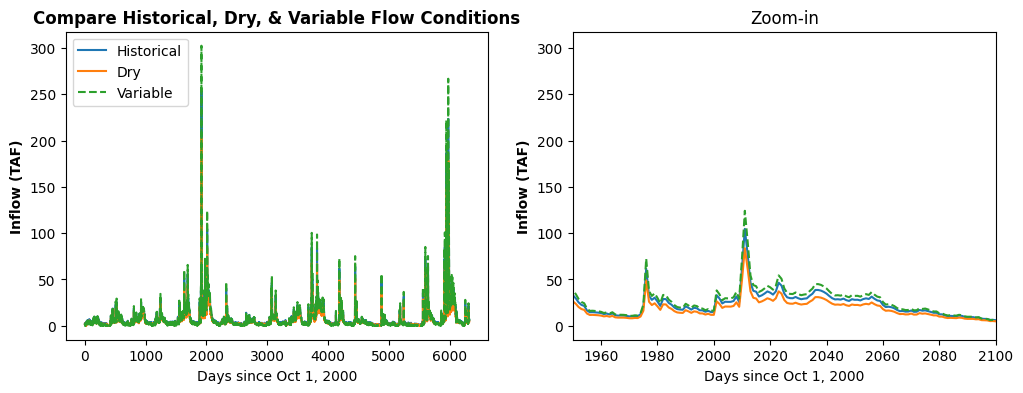

In [12]:
# Create dry_flow
dry_flow = 0.8*data.inflow

# Create variable_flow (correction for negative flows embedded)
variable_flow = np.maximum(np.mean(data.inflow) + 1.2*(data.inflow - np.mean(data.inflow)), 0)

# Plot historical, dry, and variable flow
fig, ax = plt.subplots(1,2)
#fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
ax[0].plot(data.index.to_list(), data.inflow)
ax[0].plot(data.index.to_list(), dry_flow)
ax[0].plot(data.index.to_list(), variable_flow, '--')
ax[0].set_title("Compare Historical, Dry, & Variable Flow Conditions", weight='bold')
ax[0].set_xlabel("Days since Oct 1, 2000")
ax[0].set_ylabel("Inflow (TAF)", weight='bold')
ax[0].legend(labels=['Historical', 'Dry', 'Variable'])

# zoom in on plot
ax[1].plot(data.index.to_list(), data.inflow)
ax[1].plot(data.index.to_list(), dry_flow)
ax[1].plot(data.index.to_list(), variable_flow, '--')
ax[1].set_title("Zoom-in")
ax[1].set_xlim([1950, 2100])
ax[1].set_xlabel("Days since Oct 1, 2000")
ax[1].set_ylabel("Inflow (TAF)", weight='bold')
#x[1].legend(labels=['Historical', 'Dry', 'Variable'])

In [13]:
# Simulate reservoir under new streamflow scenarios
# dry flow simulation
S, R, power, altD, relD = simulate_folsom_C(dry_flow, K, D, downstream_wse, turbine_max_outflow, efficiency)

# add these results into the original dataframe
data['S_simDry'] = pd.Series(S, index=data.index)
data['R_simDry'] = pd.Series(R, index=data.index)
data['power_simDry'] = pd.Series(power, index=data.index)

# variable flow simulation
S, R, power, altV, relV = simulate_folsom_C(variable_flow, K, D, downstream_wse, turbine_max_outflow, efficiency)

# add these results into the original dataframe
data['S_simVar'] = pd.Series(S, index=data.index)
data['R_simVar'] = pd.Series(R, index=data.index)
data['power_simVar'] = pd.Series(power, index=data.index)

Case  -- Alteration (%) -- Reliability (%)

---------------------------------------------

Historical -- 50.6124 % -- 99.5570 %

Dry        -- 61.9720 % -- 96.6936 %

Variable   -- 48.7073 % -- 95.7760 %



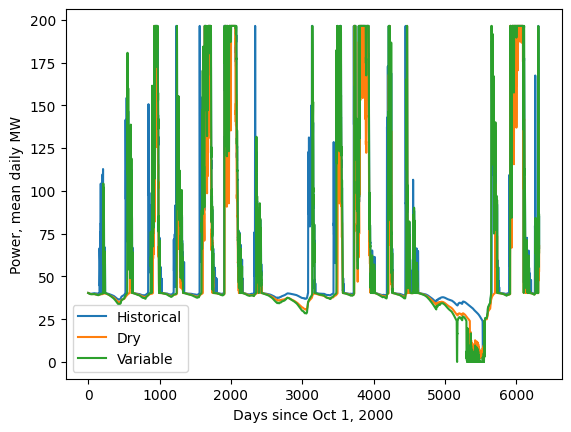

In [14]:
# report performance against reliability, alteration, and hydropower
print("Case  -- Alteration (%) -- Reliability (%)\n")
print("---------------------------------------------\n")
print("Historical -- {:.4f} % -- {:.4f} %\n".format(altH*100, relH*100))
print("Dry        -- {:.4f} % -- {:.4f} %\n".format(altD*100, relD*100))
print("Variable   -- {:.4f} % -- {:.4f} %\n".format(altV*100, relV*100))

fig, ax = plt.subplots()
data.power_sim.plot(ax=ax)
data.power_simDry.plot(ax=ax)
data.power_simVar.plot(ax=ax)
ax.set_xlabel("Days since Oct 1, 2000")
plt.ylabel('Power, mean daily MW')
plt.legend(labels=['Historical', 'Dry', 'Variable'])
plt.show()

Reliability decreases for the dry flow because there is less water available and also for the varaible flow because it is more difficult to store.